In [19]:
# Подключение и монтирование диска в GoogleColab
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir("/content/drive/My Drive/Signature")


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [20]:
# Импорт необходимых библиотек 
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
import PIL
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import skimage

In [21]:
# Глобальные переменные 
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'
img_width = 200
img_height = 100
input_shape = (img_height,img_width,1) 
batch_size = 50
target_size =  (img_height,img_width)

In [22]:
# Инициализация модели
model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=input_shape, padding='valid'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='valid'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(filters=128,kernel_size=(3,3), activation='relu', padding='valid'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(filters=128,kernel_size=(3,3), activation='relu', padding='valid'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.25)) # 0.1
model.add(layers.Dense(50,activation='softmax'))
# Вывод структуры модели
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 99, 199, 32)       160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 99, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 48, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 23, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 21, 128)       

In [23]:
# Компиляция модели
model.compile(optimizer='rmsprop', # Алгоритм обратного распространения ошибки
             loss='categorical_crossentropy', # Функция потерь - перекрестная энтропия
             metrics = ['accuracy'])

In [24]:
# Функция предобработки
def function(image):
  image[:][:][image[:][:][:]>240] = 255 # Отсечение фона
  image[:][:][:] -= 255 # Реверсия цвета так, чтобы 0.0-белый                
  image[:][:][:] *= -1  
  maximum = np.max(image) # Нормализация изображения 
  c = 255 / maximum
  image[:][:][:] *= c

  return image

In [25]:
# Датагены для обучения и проверки 
train_datagen = ImageDataGenerator(
                                  rescale=1. / 255, # Масштабирование
                                  rotation_range = 5, # Поворот
                                  zoom_range=[1.3, 1.4],                                                                   
                                  width_shift_range= [0,20], # Сдвиг по горизонтали 
                                  height_shift_range= [0,10], # Сдвиг по вертикали 
                                  preprocessing_function = function, # Функция предобработки
                                  cval = 255.0, # Значения заполнения
                                  fill_mode = 'constant' # Метод заполнения
                                   )
test_datagen = ImageDataGenerator(
                                  rescale=1. / 255,  
                                  zoom_range=[1.35, 1.35],
                                  preprocessing_function = function,
                                  cval = 255.0,
                                  fill_mode = 'constant'
                                   )

In [26]:
# Генераторы для обученя, проверки, и тестирования
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size = target_size,
    batch_size = batch_size,
    color_mode="grayscale", # Вид изображения 
    class_mode='categorical') 

val_generator = test_datagen.flow_from_directory( 
    val_dir,
    target_size = target_size,
    batch_size = batch_size,
    color_mode="grayscale",
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = target_size,
    batch_size = batch_size,
    color_mode="grayscale",
    class_mode='categorical',
    )

Found 519 images belonging to 50 classes.
Found 100 images belonging to 50 classes.
Found 100 images belonging to 50 classes.


In [ ]:
# Метод для преждевременной остановки обучения
from  keras.callbacks import Callback
class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='accuracy', value=1.00, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
    def on_epoch_end(self, epoch, logs={}):
      current = logs.get(self.monitor)
      if current is None:
          warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

      if current >= self.value:
          if self.verbose > 0:
              print("Epoch %05d: early stopping THR" % epoch)
          self.model.stop_training = True

# Обучение модели
from PIL import  Image
import keras.callbacks
history = model.fit_generator(
    train_generator,
    callbacks = [ EarlyStoppingByAccuracy(monitor='val_accuracy', value=1.00, verbose=4)],
    steps_per_epoch = 500 // batch_size, #count - общее кол-во изображений в обуч. наборе 
    epochs=50,
    validation_data= val_generator,
    validation_steps = 5)

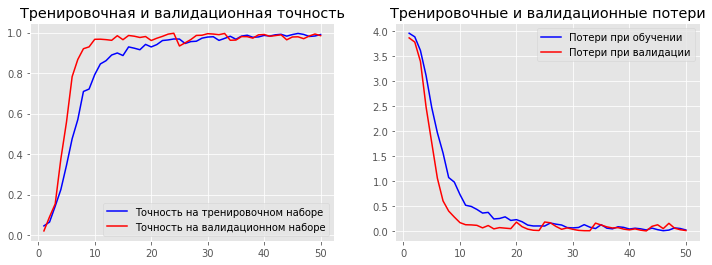

In [125]:
# Графики процесса обучения
def smooth_curve(points, factor=0.4):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, smooth_curve(acc), 'b', label='Точность на тренировочном наборе')
    plt.plot(x, smooth_curve(val_acc), 'r', label='Точность на валидационном наборе')
    plt.title('Тренировочная и валидационная точность')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, smooth_curve(loss), 'b', label='Потери при обучении')
    plt.plot(x, smooth_curve(val_loss), 'r', label='Потери при валидации')
    plt.title('Тренировочные и валидационные потери')
    plt.legend()
plot_history(history)   


(100, 200, 1)


<Figure size 432x288 with 0 Axes>

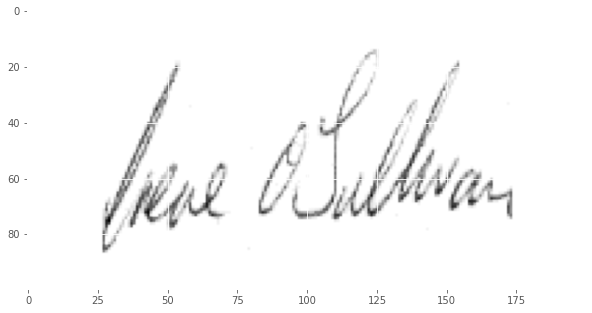

In [118]:
# Вывод изображения
i = 0 
for batch in test_generator: 
  plt.figure(i)
  tensor_img = batch[0][0]
  print(tensor_img.shape)
  new_img = np.squeeze(tensor_img, axis=(2))
  tensor_img = tensor_img.reshape((1,) + tensor_img.shape)
  plt.figure(figsize=(10,20))
  imgplot = plt.imshow(new_img,cmap='Greys')
  i += 1
  if i%1==0:
    break
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


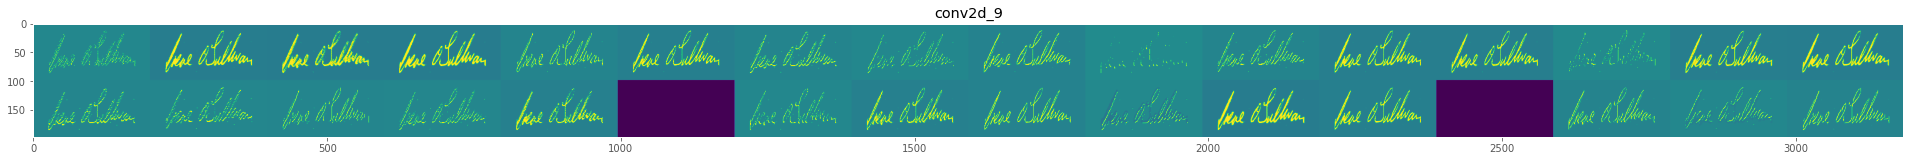

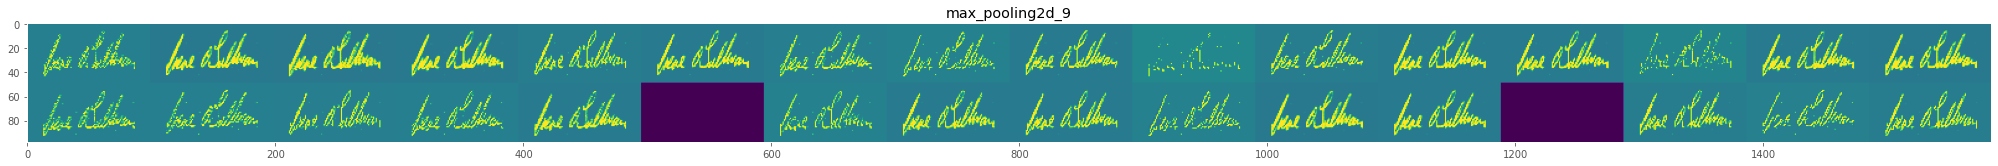

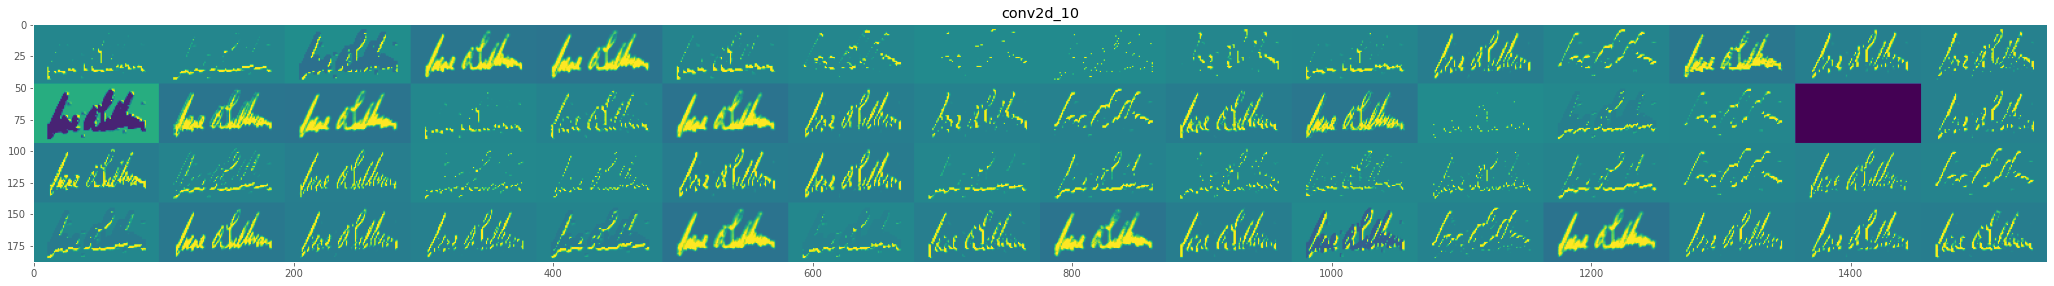

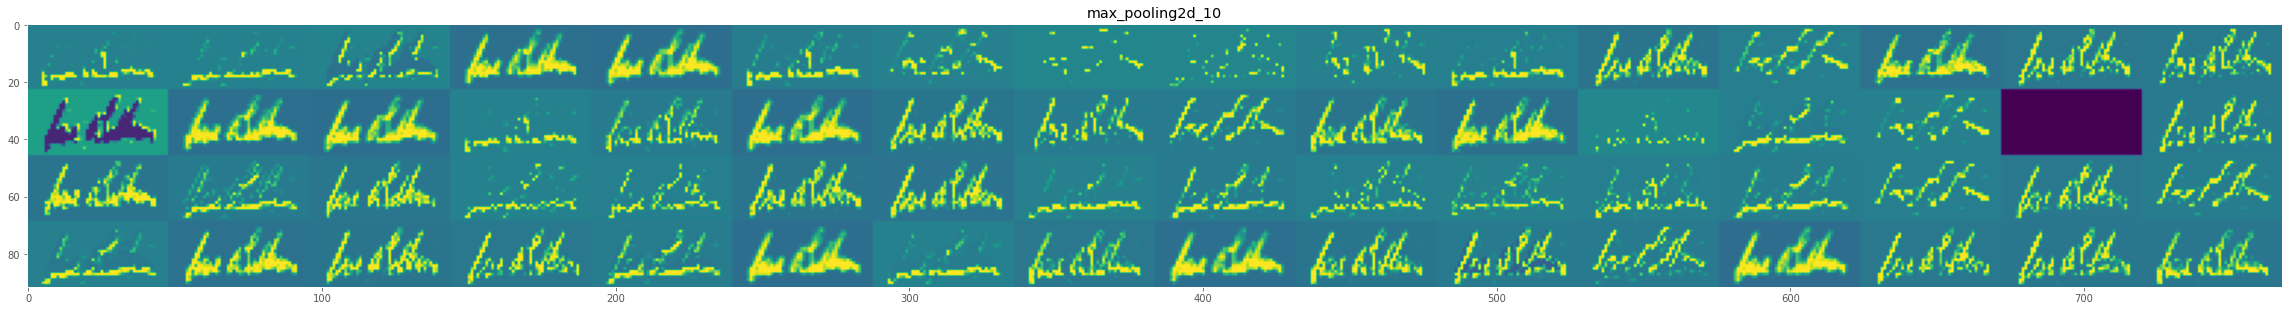

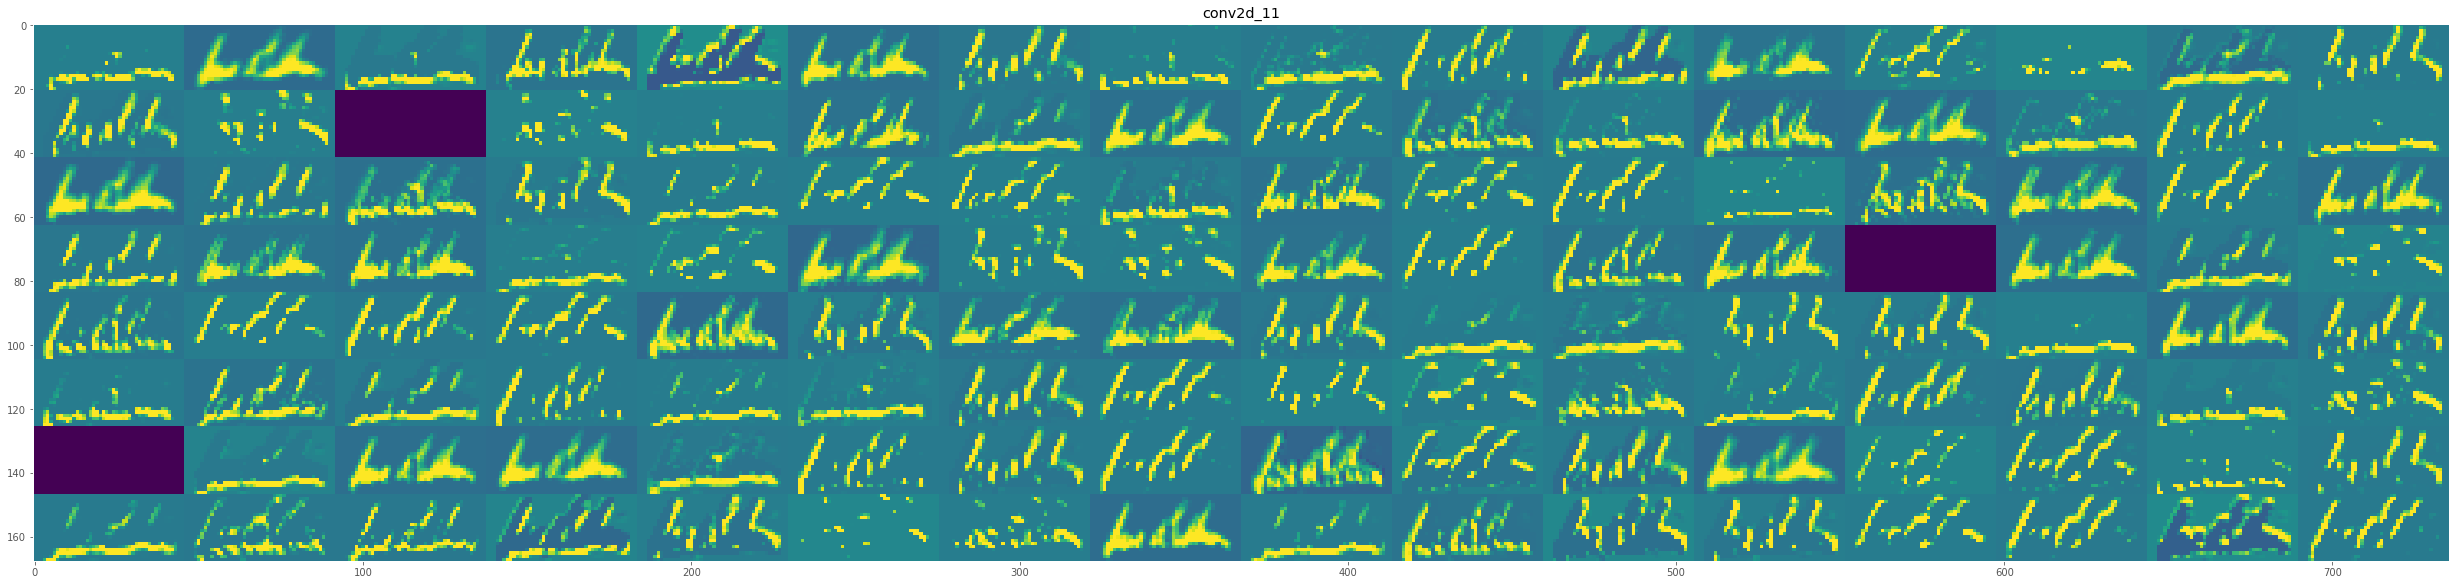

In [120]:
# Визуализация работы слоев модели
COUNT_LAYERS = 5 #  Кол-во слоев, которое надо вывести

layer_outputs = [layer.output for layer in model.layers[:COUNT_LAYERS]] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(tensor_img) 

layer_names = []
for layer in model.layers[:COUNT_LAYERS]:
    layer_names.append(layer.name) # Названия слоев 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Отображение карт признаков
    n_features = layer_activation.shape[-1] 
    height = layer_activation.shape[1]
    width = layer_activation.shape[2]
    n_cols = n_features // images_per_row 
    display_grid = np.zeros((height * n_cols, images_per_row * width))
    for col in range(n_cols): 
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * height : (col + 1) * height, 
                         row * width : (row + 1) * width] = channel_image
    scale = 1. / (height-4)
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

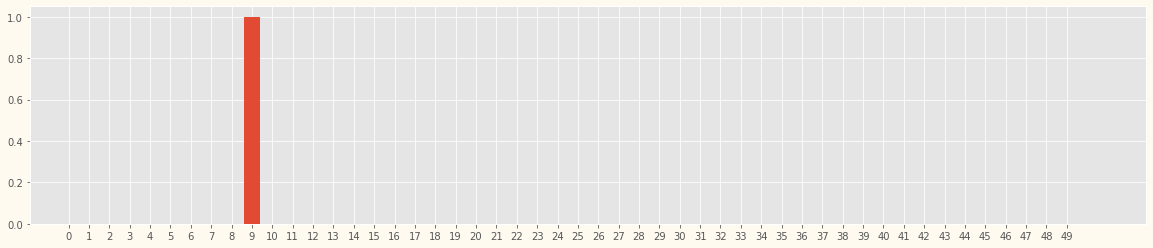

In [121]:
# Передав матрицу значений изображения методу model.predict() можно получить результат идентификации модели.


# Диаграмма результата идентификации
res = model.predict(tensor_img)[0]
# for p in res:
#   print(p)
import numpy as np
import matplotlib.pyplot as plt
x =  np.arange(1, 51)
y = res
fig, ax = plt.subplots()
ax.bar(x, y)
plt.xticks(np.arange(0, 50, step=1.0))

# ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(20)    #  ширина Figure
fig.set_figheight(4)    #  высота Figure
plt.show()

Точность: 1.0
Класс: [8]


<function matplotlib.pyplot.show>

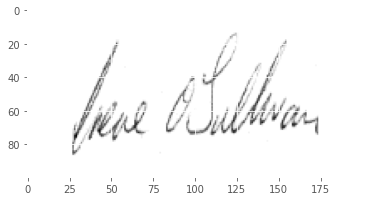

In [122]:
# Идентификация первого изображения из списка fnames

plt.figure(0)
imgplot = plt.imshow(new_img,cmap='Greys')
print("Точность: "+str(model.predict(tensor_img).max()))
print("Класс: "+str(model.predict_classes(tensor_img)))
plt.show

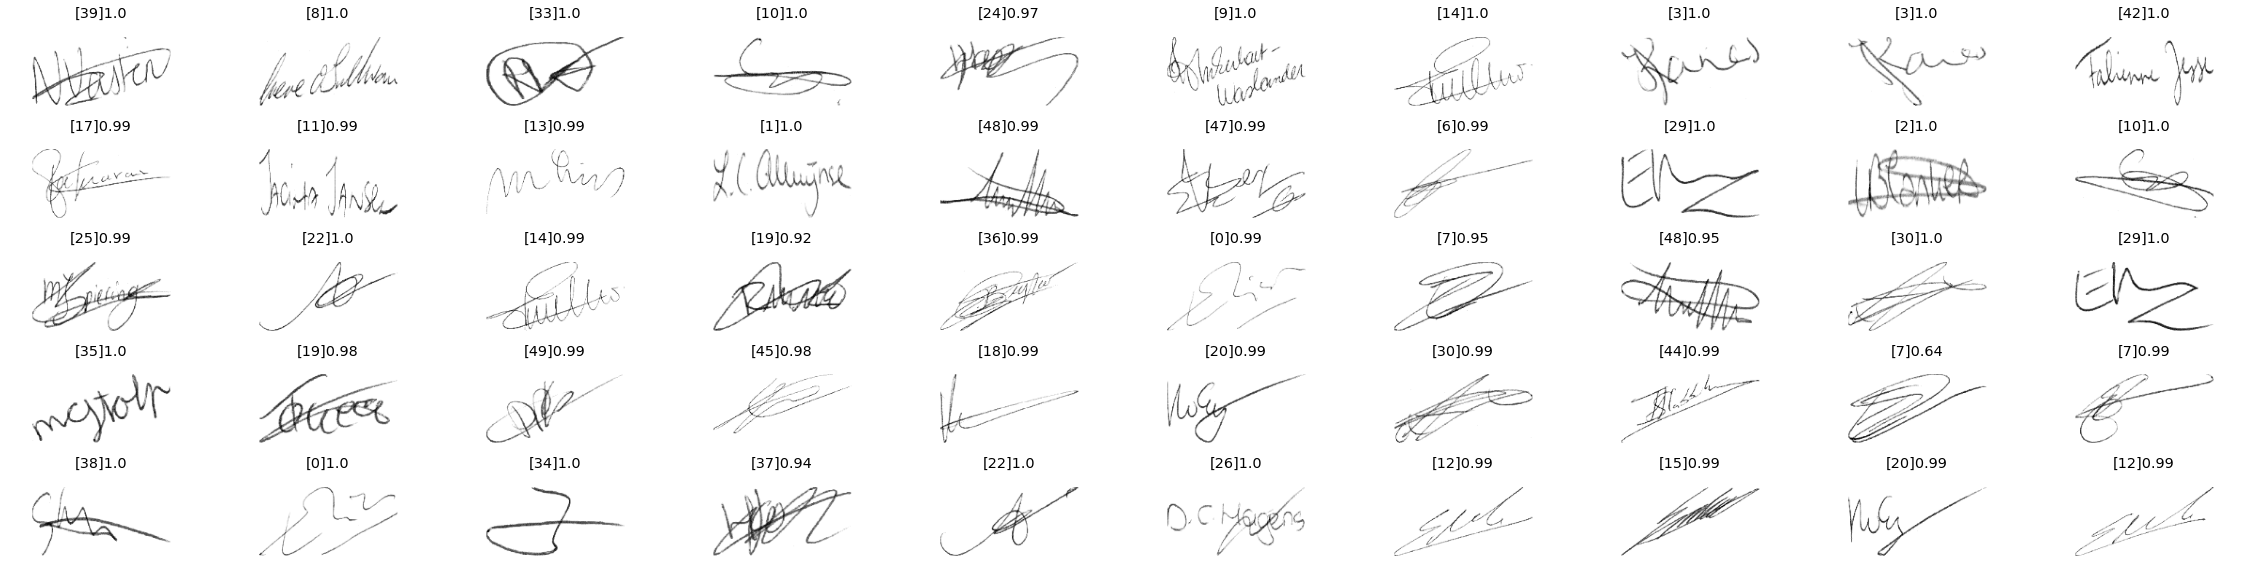

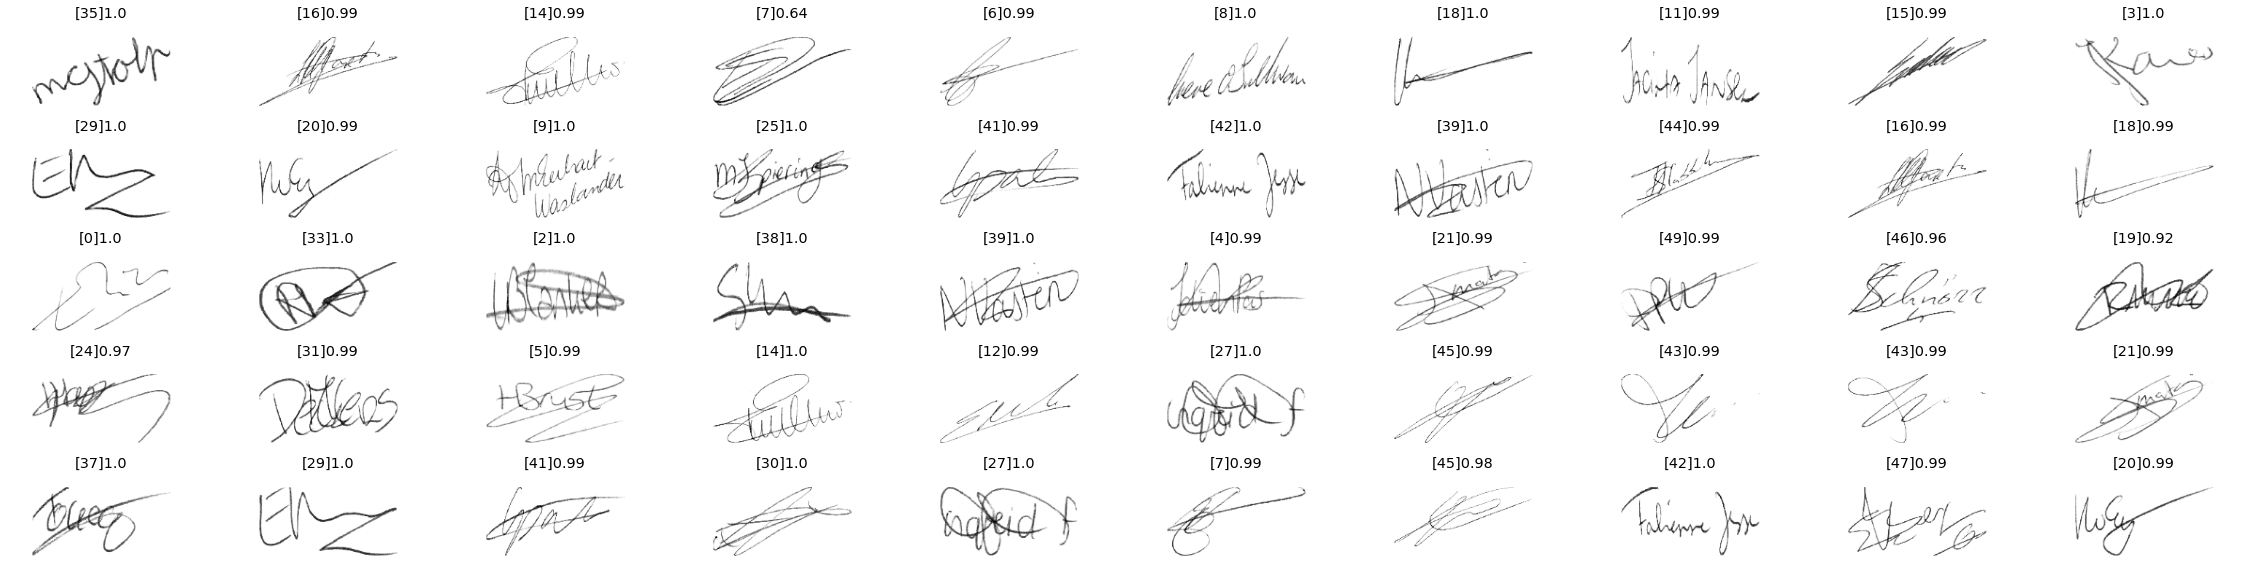

In [123]:
# Результат идентификации изображений для 100 экземпляров
count = 0
for batch in test_generator:
  if count>=100:
      break
  fig, axes = plt.subplots( 5, 10)
  i=0
  rows = len(axes)
  cols = len(axes[0])
  for row in range(len(axes)):
    for col in range(len(axes[0])):
      tensor_img = batch[0][i]
      x = tensor_img.reshape((1,) + tensor_img.shape)
      axes[row][col].set_title(str(model.predict_classes(x)) + str(model.predict(x).max())[:4])
      new_img = np.squeeze(tensor_img, axis=(2))
      axes[row][col].imshow(new_img,cmap='Greys')
      axes[row][col].set_axis_off()
      i+=1
      count+=1
  fig.set_figwidth(40)    #  ширина и
  fig.set_figheight(2*rows)  
  plt.show()